### Credit Card Fraud Detection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
import sklearn
sklearn. __version__  # Note: SMOTE library requires sklearn version ='0.23.1' or higher

'0.23.1'

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

#### Information about Data Set 
* Source : https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv

* It is a CSV file, contains 31 features, the last feature is used to classify the transaction whether it is a fraud or not. The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
* It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues original features are not provided and more background information about the data is also not present. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [58]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
## Percentage of Fraud Data i.e. data with Class 1
sum(df.Class==1)*100/len(df.Class)

0.1727485630620034

From this result we can see that data have a very imbalanced class - just 0.17% of our dataset belong to the target class!

This is a problem because many machine learning models are designed to maximize overall accuracy, which especially with imbalanced classes may not be the best metric to use. Classification accuracy is defined as the number of correct predictions divided by total predictions times 100. For example, if we simply predicted all transactions are not fraud, we would get a classification acuracy score of over 99%!

#### Scaling Time and amount data
* Since most of our data has already been scaled we should scale the columns that are left to scale i.e 'Amount' and 'Time' columns.
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

In [59]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

scaled_amount= rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
scaled_time= rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.drop(['Time','Amount'], axis=1, inplace=True)

In [60]:
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


####  Splitting Data into Train and Test Set

In [61]:
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

#### Baseline Models

In [62]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.9981461194910255


As predicted our accuracy score for classifying all transactions as not fraud is 99.8%!

As the Dummy Classifier predicts only Class 0, it is clearly not a good option for our objective of correctly classifying fraudulent transactions.

### 1. Let's see how Logistic Regression performs on this dataset.

In [63]:
# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

In [64]:
accuracy_score(y_test, lr_pred)

0.9992275497879273

In [12]:
lr_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [65]:
# Checking unique values
np.unique(lr_pred,return_counts=True)

(array([0, 1], dtype=int64), array([71111,    91], dtype=int64))

In [66]:
# Checking unique values :Another Way
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

0    71111
1       91
Name: 0, dtype: int64

In [67]:
predictions

,0
0,0
1,0
2,0
3,0
4,0
...,...
71197,0
71198,0
71199,0
71200,0


Logistic Regression outperformed the Dummy Classifier! We can see that it predicted 94 instances of class 1, so this is definitely an improvement. But can we do better?

Let's see if we can apply some techniques for dealing with class imbalance to improve these results.

### Change the performance metric
Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be misleading. Metrics that can provide better insight include:

* Confusion Matrix: a table showing correct predictions and types of incorrect predictions.
* Precision: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier's exactness. Low precision indicates a high number of false positives.
* Recall: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier's completeness. Low recall indicates a high number of false negatives.
* F1: Score: the weighted average of precision and recall.
Since our main objective with the dataset is to prioritize accuraltely classifying fraud cases the recall score can be considered our main metric to use for evaluating outcomes.

In [68]:
# f1 score
print('f1 score: ',f1_score(y_test, lr_pred),'\n')
# confusion matrix
print('confusion matrix: \n',pd.DataFrame(confusion_matrix(y_test, lr_pred)),'\n')
# recall score
print('recall score: ',recall_score(y_test, lr_pred))

f1 score:  0.7533632286995515 

confusion matrix: 
        0   1
0  71063   7
1     48  84 

recall score:  0.6363636363636364


We have a very high accuracy score of 0.999 but a F1 score of only 0.752. And from the confusion matrix, we can see we are misclassifying several observations leading to a recall score of only 0.64.

### Plotting Precision Recall Curve

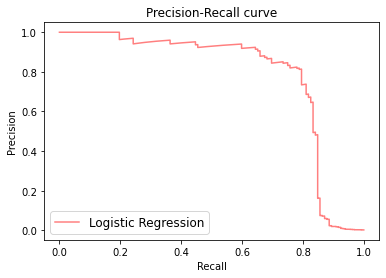

In [69]:
from sklearn.metrics import precision_recall_curve
pred_prob=lr.predict_proba(X_test)
y_score = pred_prob[:,1]
precision,recall, thresholds = precision_recall_curve(y_test, y_score)
plt.plot(recall,precision, color='red', alpha=0.5,linewidth=1.5,label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left', fontsize = 'large')

### Plotting ROC Curve

Text(0, 0.5, 'True Positive Rate')

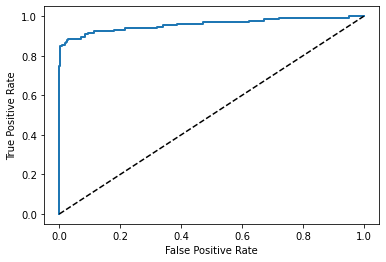

In [70]:
from sklearn.metrics import roc_curve
pred_prob=lr.predict_proba(X_test)
y_score = pred_prob[:,1]
fpr,tpr,thresholds =roc_curve(y_test, y_score)
plt.plot(fpr,tpr,linewidth=2)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Area Under the Curve (AUC)
* One way to compare the classifiers is to measure the Area Under the Curve (AUC).A perfect classifier will have a ROC AUC equal to 1 wheres a purely random classifier will have a ROC AUC =1.

In [71]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_score)

0.9587288034417625

### 2. Change the Algorithm: Trying  RandomForestClassifier
While in every machine learning problem, its a good rule of thumb to try a variety of algorithms, it can be especially beneficial with imbalanced datasets. Decision trees frequently perform well on imbalanced data. They work by learning a hierachy of if/else questions. This can force both classes to be addressed.

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)

0.999592708069998

In [19]:
# f1 score
print('f1 score: ',f1_score(y_test, rfc_pred),'\n')
# confusion matrix
print('confusion matrix: \n',pd.DataFrame(confusion_matrix(y_test, rfc_pred)),'\n')
# recall score
print('recall score: ',recall_score(y_test, rfc_pred))

f1 score:  0.879668049792531 

confusion matrix: 
        0    1
0  71067    3
1     26  106 

recall score:  0.803030303030303


### 3. Resampling Techniques
### 3.1. Oversampling Minority Class
Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don't have a ton of data to work with. A con to consider when undersampling is that it can cause overfitting and poor generalization to your test set.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.
#### Important Note
Always split into test and train sets BEFORE trying any resampling techniques! Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets! This can allow our model to simply memorize specific data points and cause overfitting.

In [21]:
from sklearn.utils import resample

In [22]:
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [23]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264873,161634.0,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,...,0.231624,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,2.74,0
163821,116237.0,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,...,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,38.44,0
72083,54557.0,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,...,0.009073,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,1.00,0
196949,131771.0,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,...,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,37.89,0
126213,77959.0,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,...,-0.072349,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,237.00,0


In [24]:
# separate minority and majority classes
not_fraud = X[X.Class==0]
fraud = X[X.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.Class.value_counts()

1    213245
0    213245
Name: Class, dtype: int64

In [25]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.Class
X_train = upsampled.drop('Class', axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)
accuracy_score(y_test, upsampled_pred)

0.9807589674447347

In [26]:
# f1 score
print('f1 score: ',f1_score(y_test, upsampled_pred),'\n')
# confusion matrix
print('confusion matrix: \n',pd.DataFrame(confusion_matrix(y_test, upsampled_pred)),'\n')
# recall score
print('recall score: ',recall_score(y_test, upsampled_pred))

f1 score:  0.14375000000000002 

confusion matrix: 
        0     1
0  69717  1353
1     17   115 

recall score:  0.8712121212121212


Our accuracy score decreased after upsampling, but the model is now predicting both classes more equally, making it an improvement over our plain logistic regression above.

### 3.2. Undersampling Majority Class
Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback to undersampling is that we are removing information that may be valuable.

We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class.

In [27]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

1    360
0    360
Name: Class, dtype: int64

In [28]:
# trying logistic regression again with the undersampled dataset

y_train = downsampled.Class
X_train = downsampled.drop('Class', axis=1)

undersampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

undersampled_pred = undersampled.predict(X_test)
accuracy_score(y_test,undersampled_pred)

0.9758574197354007

In [29]:
# f1 score
print('f1 score: ',f1_score(y_test, undersampled_pred),'\n')
# confusion matrix
print('confusion matrix: \n',pd.DataFrame(confusion_matrix(y_test, undersampled_pred)),'\n')
# recall score
print('recall score: ',recall_score(y_test, undersampled_pred))

f1 score:  0.11710323574730355 

confusion matrix: 
        0     1
0  69369  1701
1     18   114 

recall score:  0.8636363636363636


Downsampling produced a higher recall score than upsampling! One concern here is the small number of total samples we used to train the model.

### 4. Generate Synthetic Samples: Using SMOTE
SMOTE or Synthetic Minority Oversampling Technique is a popular algorithm to creates sythetic observations of the minority class.

https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

In [29]:
## !pip install imbalanced-learn ## Install if not 

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

X_train, y_train = SMOTE(random_state=27).fit_resample(X_train, y_train)

In [32]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote.predict(X_test)

# Checking accuracy
accuracy_score(y_test, smote_pred)

0.9858571388444145

In [33]:
# f1 score
print('f1 score: ',f1_score(y_test, smote_pred),'\n')
# confusion matrix
print('confusion matrix: \n',pd.DataFrame(confusion_matrix(y_test, smote_pred)))
# recall score
print('recall score: ',recall_score(y_test, smote_pred))

f1 score:  0.18461538461538463 

confusion matrix: 
        0    1
0  70081  989
1     18  114
recall score:  0.8636363636363636


##### Conclusion
We covered 4 different methods for dealing with imbalanced datasets: With the performance metric associated with Confusion Matrix

* Oversampling minority class
* Undersampling majority class
* Change the algorithm
* Generate synthetic samples

###### These are just some of the many possible methods to try when dealing with imbalanced datasets, and not an exhaustive list. Some others methods to consider are collecting more data or choosing different resampling ratios - you don't have to have exactly a 1:1 ratio! You should always try several approaches and then decide which is best for your problem.